<a href="https://colab.research.google.com/github/theSC0RP/Neural-Style-Transfer/blob/master/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Article 1 - Breaking Down Neural Style Transfer](https://towardsdatascience.com/breaking-down-leon-gatys-neural-style-transfer-in-pytorch-faf9f0eb79db)

[Article 2 - Neural Style Transfer tutorial](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f)

1. Get the content activations of the noise image out of the VGG ("block4_conv2")
2. “Unroll” the content activations of the noise image
3. Calculate the content loss: SSE between the content activations of the content image and content activations of the noise image
4. Get the style activations of the noise image out of the VGG (“block1_conv1”, “block2_conv1”, “block3_conv1”, “block4_conv1”, “block5_conv1”)
5. “Unroll” the style activations of the noise image
6. Calculate the Gram matrices for each layer of the style activations of the noise image
7. Add the weighted style losses for each layer together
8. Add the weighted style and content losses together
9. Back-propagate
10. Update the pixels of the noise image
11. Repeat 1–10


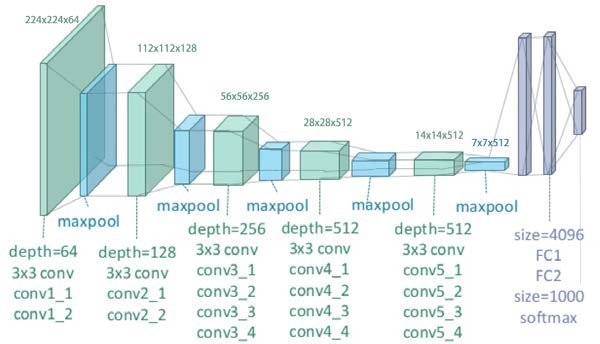

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
from torchvision import models, transforms

### Defining the model (VGG19)

In [0]:
model = models.vgg19(pretrained=True).features

In [0]:
for param in model.parameters():
  param.requieres_grad = False

In [0]:
model = model.to('cuda')

### Data Loading and Visualization

In [0]:
from PIL import Image
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
def image_loader(path):
  image = Image.open(path)
  image = transform(image).float()
  image = image.unsqueeze(0)
  return image

In [0]:
content = image_loader('/content/drive/My Drive/Datasets/NST Images/content_cat.jpg')
style = image_loader('/content/drive/My Drive/Datasets/NST Images/style_the_starry_night.jpg')
target = content.clone()

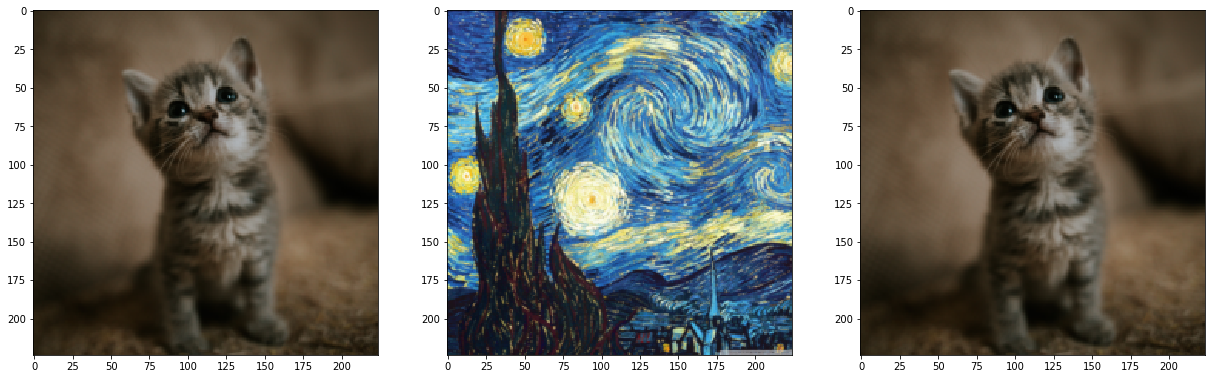

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
plt.imshow(content[0].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(style[0].permute(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(target[0].permute(1, 2, 0))

In [0]:
content = content.to('cuda')
style = style.to('cuda')
target = target.requires_grad_(True)

In [10]:
model_layers = model._modules.items()
for item in model_layers:
  print(item)

('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('1', ReLU(inplace=True))
('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('3', ReLU(inplace=True))
('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('6', ReLU(inplace=True))
('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('8', ReLU(inplace=True))
('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('11', ReLU(inplace=True))
('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('13', ReLU(inplace=True))
('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('15', ReLU(inplace=True))
('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
('17', ReLU(inplace=True))
('18', MaxPool2d(kernel_si

### Get Features

In [0]:
style_layers = ['0', '5', '10', '19', '28']

In [0]:
def get_features(img):
  content_activations, style_activations = [], []
  x = img
  
  for i, layer in model_layers:
    x = layer(x)

    if i == '21':
      content_activations.append(x.squeeze())

    if i in style_layers:
      style_activations.append(x.squeeze())


  return  (content_activations, style_activations)

### Gram Matrix Function

In [0]:
def calc_gram(x):
  return torch.mm(x, x.t())

### Features of Content Image

In [0]:
content_features = get_features(content)[0][0].detach()

In [0]:
content_features = content_features.view(512, -1)

### Features of Style Image

In [0]:
style_features = get_features(style)[1]

In [0]:
for i, style_feature in zip(range(len(style_features)), style_features):
  style_features[i] = style_feature.view(style_feature.shape[0], -1).detach()

In [0]:
gram_matrices = [calc_gram(style_feature) for style_feature in style_features]

### Content Loss

In [0]:
def get_content_loss(target_img):
  target_content_features = get_features(target_img)[0][0]
  target_content_features = target_content_features.view(512, -1)
  
  c_loss = (((content_features - target_content_features) ** 2).sum())/2.0
  return c_loss

### Style Loss

In [0]:
def get_style_loss(target_img):
  target_style_features = get_features(target_img)[1]

  for i, style_f in zip(range(len(target_style_features)), target_style_features):
    style_f = style_f.view(style_f.shape[0], -1)
    target_style_features[i] = style_f

  target_gram_matrices = [calc_gram(s_f) for s_f in target_style_features]
  
  losses = []
  for i in range(len(gram_matrices)):
    d, h_w = target_style_features[i].shape
    losses.append((((gram_matrices[i] - target_gram_matrices[i]) ** 2).sum())/(4 * d**2 * h_w **2 ))
  
  s_loss = 0
  weights = [1., 1., 1., 1., 1.]
  for i in range(len(weights)):
    s_loss += weights[i] * losses[i]
  
  return s_loss

In [0]:
num_epochs = 10
learning_rate = 1e-3

In [0]:
optimizer = torch.optim.Adam([target], lr = learning_rate)

In [0]:
alpha = 0.5
beta = 0.5

In [26]:
plt.figure(figsize=(20, 8))
target = target.to('cuda')
for i in range(10):
  optimizer.zero_grad()

  content_loss = get_content_loss(target)
  style_loss = get_style_loss(target)
  loss = alpha * content_loss + beta * style_loss

  loss.backward()
  optimizer.step()
  
  print("Loss after: ", loss)
  
  # if i % 10 == 0:
  #   plt.subplot(2, 5, i/10)
  #   plt.imshow(target.cpu()[0].permute(1, 2, 0))

Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)
Loss after:  tensor(0.4035, device='cuda:0', grad_fn=<AddBackward0>)


<Figure size 1440x576 with 0 Axes>